<a href="https://colab.research.google.com/github/Riddars/Dream_team/blob/main/LazyRegressor/LazyRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загружаю библиотеки

In [1]:
! pip install lazypredict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

import lazypredict
from lazypredict.Supervised import LazyRegressor #Regression

from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split # data split

import pickle

# LazyPredict

При помощи библиотеки LazyPredict подбираем модель регрессии

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/Riddars/Dream_team/main/Imputed_data.csv', index_col=0)

x = df.columns
target_name = 'ZOI_drug_NP'

X, y = df[x.drop(target_name)], df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [5]:
reg = LazyRegressor(predictions=True)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [00:10<00:00,  4.09it/s]


In [6]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.74,0.80,3.97,0.21
GradientBoostingRegressor,0.73,0.78,4.10,0.14
RandomForestRegressor,0.72,0.78,4.12,0.57
XGBRegressor,0.72,0.78,4.16,0.27
BaggingRegressor,0.72,0.78,4.18,0.07
LGBMRegressor,0.66,0.73,4.59,0.45
HistGradientBoostingRegressor,0.65,0.72,4.65,0.42
AdaBoostRegressor,0.65,0.72,4.66,0.30
LassoLarsIC,0.64,0.72,4.70,0.04


Для модели с лучшими результатами R**2 и RMSE подбираем оптимальные параметры при помощи gridsearchCV

In [7]:
def make_gridsearchCV(models_params: list, df: pd.DataFrame, test_size=0.25, cv=4, random_state=123, target_name='ZOI_drug_NP'):

    X, y = df[x.drop(target_name)], df[target_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    models = []

    for model in models_params:

        pipe = Pipeline([('scaler', MinMaxScaler()), ('model', model[0])])
        grid = GridSearchCV(pipe, model[1], scoring='r2', n_jobs=-1, cv=cv)
        grid.fit(X_train, y_train)

        print(f'--- Model: {pipe["model"].__class__.__name__} ---\n')
        print(f'Best params: {grid.best_params_}')
        print(f'Best CV R2 score: {grid.best_score_}')
        print(f'R2 score on unseen data: {r2_score(y_test, grid.best_estimator_.predict(X_test))}')

        models.append(grid.best_estimator_['model'])

    return models

In [8]:
ex_tree = ExtraTreesRegressor(random_state=123, n_jobs=-1)
tree_params = {
    'model__max_depth': [10, 50, 100],
    'model__n_estimators': [50, 75, 100, 150],
    # 'model__criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
    'model__criterion': ['squared_error', 'mean_squared_error'],
    'model__min_samples_split': [2, 3, 4],
    }
models_params = [[ex_tree, tree_params]]
models = make_gridsearchCV(models_params, df, cv=4)

--- Model: ExtraTreesRegressor ---

Best params: {'model__criterion': 'squared_error', 'model__max_depth': 10, 'model__min_samples_split': 4, 'model__n_estimators': 50}
Best CV R2 score: 0.7868083208778351
R2 score on unseen data: 0.8124122189632959


In [9]:
ex_tree = ExtraTreesRegressor(max_depth=10, min_samples_split=4, n_estimators=50, n_jobs=-1, random_state=123).fit(X_train, y_train)
print(f'R2 score on unseen data: {r2_score(y_test, ex_tree.predict(X_test))}')
print(f'RMSE score on unseen data: {(mean_squared_error(y_test, ex_tree.predict(X_test)))**0.5}')

R2 score on unseen data: 0.8263651055013683
RMSE score on unseen data: 3.6806335383167674


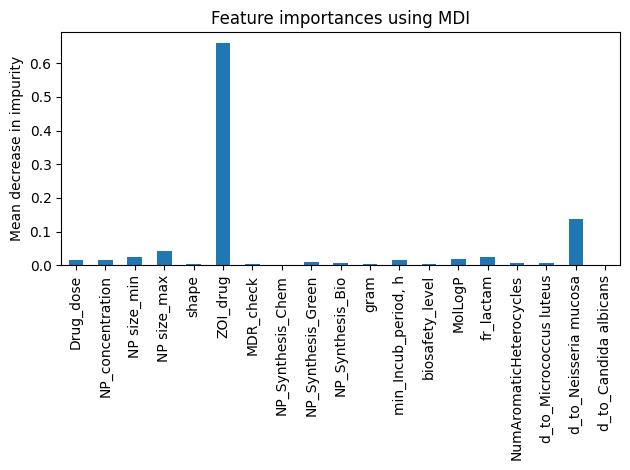

In [10]:
importances = ex_tree.feature_importances_

ex_tree_importances = pd.Series(importances, index=x.drop(target_name))
std = np.std([ex_tree.feature_importances_ for tree in ex_tree.estimators_], axis=0)

fig, ax = plt.subplots()
ex_tree_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Обучаю модельку на полном датасете

In [11]:
ex_tree = ExtraTreesRegressor(max_depth=10, min_samples_split=4, n_estimators=50, n_jobs=-1, random_state=123).fit(X, y)
print(f'R2 score on unseen data: {r2_score(y, ex_tree.predict(X))}')
print(f'RMSE score on unseen data: {(mean_squared_error(y, ex_tree.predict(X)))**0.5}')

R2 score on unseen data: 0.9604002919920812
RMSE score on unseen data: 1.6126788464050525


Сохроняю модельку

In [14]:
# import pickle
filename = 'ExtraTreesRegressor.sav'
pickle.dump(ex_tree, open(filename, 'wb'))